<a href="https://colab.research.google.com/github/kapilsingh9069/CabPricePrediction/blob/main/cab_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import pandas as pd
import numpy as np
from fancyimpute import KNN

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [6]:
train = pd.read_csv("https://raw.githubusercontent.com/Priyankk18k/CabPrediction/master/train_cab.csv")
test = pd.read_csv("https://raw.githubusercontent.com/Priyankk18k/CabPrediction/master/test.csv")
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [7]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [8]:
train.describe(include='all')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16043,16067,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
unique,468,16021,NaN,NaN,NaN,NaN,NaN
top,6.5,2010-03-12 13:30:00 UTC,NaN,NaN,NaN,NaN,NaN
freq,759,2,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,NaN,NaN,10.578384,6.826587,10.575062,6.187087,60.844122
min,NaN,NaN,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,NaN,NaN,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,NaN,NaN,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,NaN,NaN,-73.966838,40.767381,-73.963643,40.768013,2.000000


In [9]:
print(train.dtypes)

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object


In [10]:
print(test.dtypes)

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object


In [11]:
train.shape

(16067, 7)

In [12]:
test.shape

(9914, 6)

In [13]:
train['fare_amount'] = pd.to_numeric(train['fare_amount'], errors='coerce')
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], errors='coerce')

# ***DATA CLEANING***

In [14]:
# changing the values to its absolute for easier calculation further
train = train[abs(train['pickup_latitude']) < 90]
train = train[abs(train['dropoff_latitude']) < 90]
train = train[abs(train['pickup_longitude']) < 180]
train = train[abs(train['dropoff_longitude']) < 180]

In [15]:
# delete the passenger_count which is greater than 7 bcoz a cab can carry at a time only 7 passenger 
index_pc = train.loc[train.passenger_count > 7, :].index
train.drop(index_pc, axis=0, inplace=True)

In [16]:
# delete the fair_amount which is small then 0 or greater than 100
index_fc = train.loc[train.fare_amount >100, :].index
train.drop(index_fc, axis=0, inplace=True)

In [17]:
index_fc1 = train.loc[train.fare_amount < 0, :].index
train.drop(index_fc1, axis=0, inplace=True)

In [18]:
train = train.dropna(subset=['fare_amount'])
train = train.dropna(subset=['pickup_datetime'])

In [19]:
#change the value of 0 to nan so that we can impute easily during missing values
train=train.replace(0, np.nan)
print(train.shape)

(16009, 7)


In [20]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0


# ***FEATURE ENGINEERING***

In [21]:
# Datetime break into year, month, weekdays and hours 
#changing the datatype ti int

train['year'] = train['pickup_datetime'].dt.year
train['month'] = train['pickup_datetime'].dt.month
train['weekday'] = train['pickup_datetime'].dt.weekday
train['hour'] = train['pickup_datetime'].dt.hour


In [22]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


In [23]:
train = train.drop('pickup_datetime', axis=1)

In [24]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


# ***MISSING VALUE ANALYSIS***

In [25]:
print(train.isnull().sum())

fare_amount            1
pickup_longitude     310
pickup_latitude      310
dropoff_longitude    309
dropoff_latitude     307
passenger_count      112
year                   0
month                  0
weekday                0
hour                   0
dtype: int64


In [26]:
print(train.isnull().count())

fare_amount          16009
pickup_longitude     16009
pickup_latitude      16009
dropoff_longitude    16009
dropoff_latitude     16009
passenger_count      16009
year                 16009
month                16009
weekday              16009
hour                 16009
dtype: int64


In [27]:
#find out the percent of null columns:
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count()).sort_values(ascending=False))*100

missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data = missing_data.sort_values('Total',ascending= True)
print(missing_data)

                   Total   Percent
hour                   0  0.000000
weekday                0  0.000000
month                  0  0.000000
year                   0  0.000000
fare_amount            1  0.006246
passenger_count      112  0.699606
dropoff_latitude     307  1.917671
dropoff_longitude    309  1.930164
pickup_latitude      310  1.936411
pickup_longitude     310  1.936411


In [28]:
# best imputing is done by KNN that's why imputing with KNN not with mean and median
train = pd.DataFrame(KNN(k=5).fit_transform(train),columns=train.columns, index=train.index)

Imputing row 1/16009 with 0 missing, elapsed time: 42.461
Imputing row 101/16009 with 0 missing, elapsed time: 42.463
Imputing row 201/16009 with 0 missing, elapsed time: 42.464
Imputing row 301/16009 with 0 missing, elapsed time: 42.465
Imputing row 401/16009 with 0 missing, elapsed time: 42.467
Imputing row 501/16009 with 0 missing, elapsed time: 42.468
Imputing row 601/16009 with 0 missing, elapsed time: 42.469
Imputing row 701/16009 with 0 missing, elapsed time: 42.471
Imputing row 801/16009 with 0 missing, elapsed time: 42.472
Imputing row 901/16009 with 0 missing, elapsed time: 42.473
Imputing row 1001/16009 with 0 missing, elapsed time: 42.475
Imputing row 1101/16009 with 0 missing, elapsed time: 42.475
Imputing row 1201/16009 with 0 missing, elapsed time: 42.476
Imputing row 1301/16009 with 0 missing, elapsed time: 42.477
Imputing row 1401/16009 with 0 missing, elapsed time: 42.478
Imputing row 1501/16009 with 0 missing, elapsed time: 42.479
Imputing row 1601/16009 with 0 missi

In [29]:
# change datadypes into int 
train.dtypes

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
year                 float64
month                float64
weekday              float64
hour                 float64
dtype: object

In [30]:
train['passenger_count']=train['passenger_count'].astype(int)
train['year']=train['year'].astype(int)
train['month']=train['month'].astype(int)
train['weekday']=train['weekday'].astype(int)
train['hour']=train['hour'].astype(int)
train.dtypes


fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
year                   int64
month                  int64
weekday                int64
hour                   int64
dtype: object

In [31]:
# find absolute longitude and latitude
train['abs_longi']=abs(train['pickup_longitude']-train['dropoff_longitude'])

train['abs_lat']=abs(train['pickup_latitude']-train['dropoff_latitude'])

In [32]:
#Calculatig distance from log and lati with circle formula
def great_circle_distance(lon1,lat1,lon2,lat2):
    R = 6371000 # Approximate mean radius of earth (in mt)
    # Convert decimal degrees to radians
    lon1,lat1,lon2,lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Distance of lons and lats in radians
    dis_lon = lon2 - lon1
    dis_lat = lat2 - lat1
    
    # Haversine implementation
    a = np.sin(dis_lat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dis_lon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    dis_m = R*c # Distance in meters
    dis_km = dis_m/1000 # Distance in km
    return dis_km
train['distance'] = great_circle_distance(train.pickup_longitude, train.pickup_latitude, train.dropoff_longitude, train.dropoff_latitude)
train.head(10)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,abs_longi,abs_lat,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17,0.002701,0.009041,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16,0.036780,0.070701,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0,0.008504,0.010708,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4,0.004437,0.024949,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7,0.011440,0.015754,1.999157
5,12.1,-74.000964,40.731630,-73.972892,40.758233,1,2011,1,3,9,0.028072,0.026603,3.787239
6,7.5,-73.980002,40.751662,-73.973802,40.764842,1,2012,11,1,20,0.006200,0.013180,1.555807
7,16.5,-73.951300,40.774138,-73.990095,40.751048,1,2012,1,2,17,0.038795,0.023090,4.155444
9,8.9,-73.980658,40.733873,-73.991540,40.758138,2,2009,9,2,1,0.010882,0.024265,2.849627
10,5.3,-73.996335,40.737142,-73.980721,40.733559,1,2012,4,6,7,0.015614,0.003583,1.374577


# ***UNIVARIATE ANALYSIS***

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 15
fig_size[1] = 10

Text(0.5, 1.0, 'fare_amount')

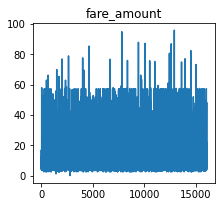

In [34]:
plt.subplot(3,4,1)
plt.plot(train['fare_amount'])
plt.title('fare_amount')

Text(0.5, 1.0, 'dropoff_longitude')

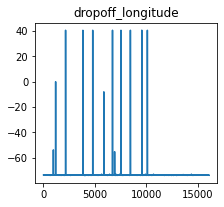

In [35]:
plt.subplot(3,4,2)
plt.plot(train['dropoff_longitude'])
plt.title('dropoff_longitude')

Text(0.5, 1.0, 'dropoff_latitude')

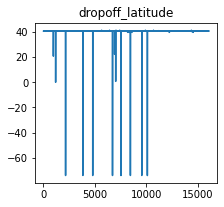

In [36]:
plt.subplot(3,4,3)
plt.plot(train['dropoff_latitude'])
plt.title('dropoff_latitude')

Text(0.5, 1.0, 'passenger_count')

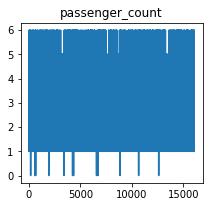

In [37]:

plt.subplot(3,4,4)
plt.plot(train['passenger_count'])
plt.title('passenger_count')

Text(0.5, 1.0, 'pickup_latitude')

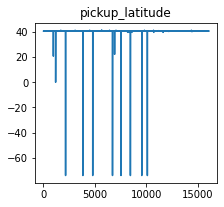

In [38]:
plt.subplot(3,4,5)
plt.plot(train['pickup_latitude'])
plt.title('pickup_latitude')

Text(0.5, 1.0, 'pickup_longitude')

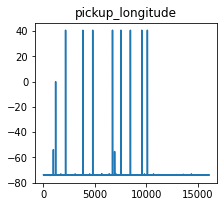

In [39]:
plt.subplot(3,4,6)
plt.plot(train['pickup_longitude'])
plt.title('pickup_longitude')

Text(0.5, 1.0, 'abs_longi')

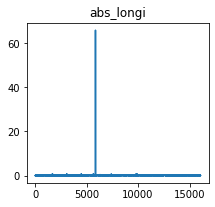

In [40]:
plt.subplot(3,4,7)
plt.plot(train['abs_longi'])
plt.title('abs_longi')

Text(0.5, 1.0, 'abs_lat')

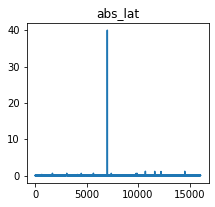

In [41]:
plt.subplot(3,4,8)
plt.plot(train['abs_lat'])
plt.title('abs_lat')

Text(0.5, 1.0, 'distance')

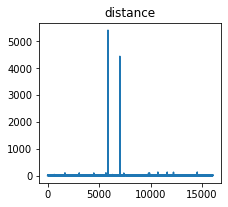

In [42]:
plt.subplot(3,4,9)
plt.plot(train['distance'])
plt.title('distance')

# ***BIVARIATE ANALYSIS***

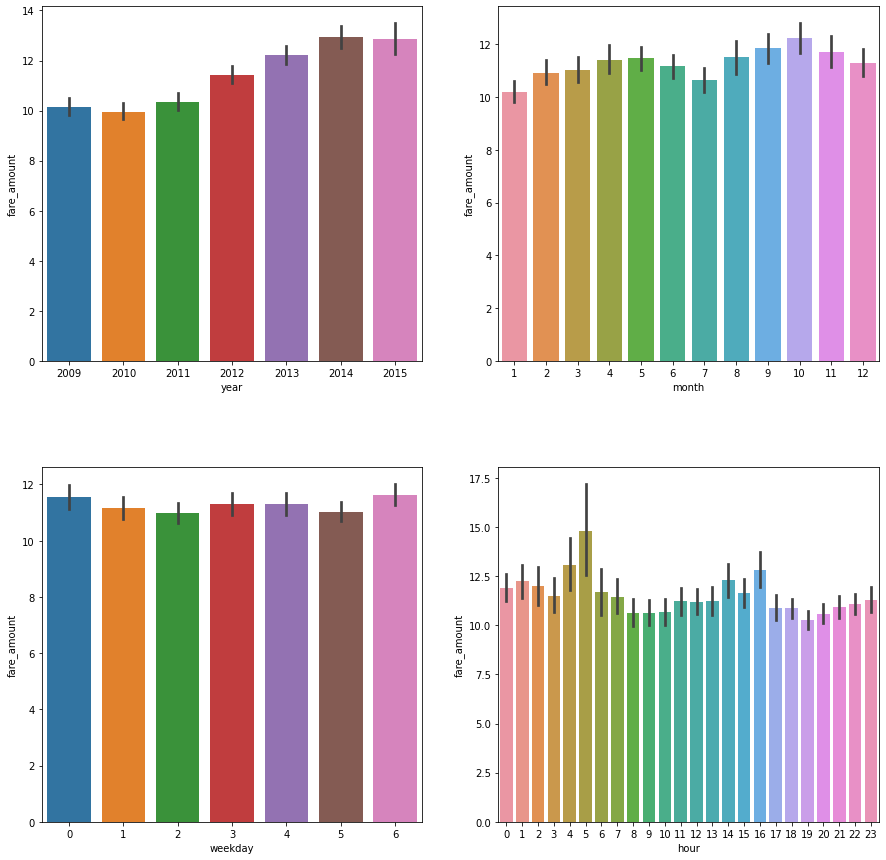

In [49]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=.3)

sns.barplot(x='year' ,y='fare_amount',data=train, ax=axarr[0][0])

sns.barplot(x='month',y='fare_amount',data=train, ax=axarr[0][1])

sns.barplot(x='weekday',y='fare_amount',data=train, ax=axarr[1][0])

sns.barplot(x='hour',y='fare_amount',data=train, ax=axarr[1][1])
